# The Problem of Loanwords: Detection and Remedies

## What is a Loanword?
They are real: https://en.wikipedia.org/wiki/Loanword but they often overlooked in everyday use. Take this example conversation:
* "It was nice seeing you again. Adios amigo."
* "Vaya con Dios!"
#### The last two sentences are loanwords, borrowings from Spanish. Most participants can navigate and interpret conversations even if they don't know the exact translations of the loanwords.

However, when doing Natural Language Processing loanwords may become a pesky problem, for example:
* If you are trying to generate a high quality embedding
    * you many need to detect and drop out the loanwords since they are out of scope for typical monolingual embeddings.
* If your application is translating a sequence of sentences
    * you may need to switch models to create a better translation of a loanword sequence.
* Some loanwords may occur in both languages 
    * you will need to use other heuristic measures to increase your precision and recall in detection.
#### etc.
### So let's look at how we can detect and work around these problem areas.

### In this notebook you will:
1. Perform ETL (Extract-Transform-Load)
    1. Extract data using a Corpus Reader object
    1. Transform the data using a reusable, composable Scikit-Learn Pipeline object
    1. Load the data into a matrix and train a classifier
1. Train several classifiers and select the best algorithm for the data
1. Use GridSearch to tune hyperparameters to achieve the best algorithm performance
1. Use the classifier to predict the classification of each word
1. Extract whole phrases by clustering occurences of predicted words 
1. Save the pipelines and classifier for reuse at runtime
1. Record the trained classifier model's provenance
1. Examine some unseen, untrained data to discover how well the classifier generalizes to unseen data

## Our problem: Detect Transliterated Greek in Classical Latin Authors
### Why? 
### To make a high quality word embedding, using a relatively limited corpus, it's important to filter out foreign words. Often Latin authors will quote Greek authors and transliterate the Greek into Latin equivalents; however the resulting words often haven't been generally adopted in the language. True, some transliterated Greek words are valid Latin words, but we aren't concerned about a word here or there, but rather clusters of foreign words in the source language. 
### The data sets are from CLTK (Classical Language Toolkit http://cltk.org/ ):
* The Latin Library
    * Julius Caesar
    * Prudentius
    * Eutropius
* The Perseus Library Greek Texts
    * The Works of Plato
    * Homer's Odyssey
* We will augment our Latin data set using probability distributions in tandem with CLTK's lemmatization dictionary.

#### The probability distributions come from our other notebooks:
* `building_language_model/make_frequency_distribution.ipynb` 
* `detecting_loanwords/make_frequency_distribution_greek_transliterated.ipynb`

#### The Greek will be transliterated into Latin. 
#### We will use our classifier to examine the corpus of Pliny the Younger to detect the use of transliterated Greek words, and we'll assess the classifier's effectiveness on the entire Latin Library corpus.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Imports

In [2]:
import datetime
import glob
import json
import logging
import multiprocessing
import os
import site
from copy import deepcopy
import random
from collections import defaultdict
import pickle

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from tqdm import tqdm
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.extmath import density
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from joblib import dump, load
import sklearn
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from cltk.stem.latin.j_v import JVReplacer
from cltk.prosody.latin.scansion_constants import ScansionConstants
from cltk.prosody.latin.string_utils import remove_punctuation_dict
from cltk.tokenize.word import WordTokenizer
from cltk.corpus.readers import get_corpus_reader
from cltk.utils.featurization import word_to_features
from cltk.utils.file_operations import md5
from cltk.utils.matrix_corpus_fun import (
    distinct_words,
    separate_camel_cases,
    drop_empty_lists,
    drop_non_lower,
    drop_arabic_numeric,
    drop_all_caps,
    drop_empty_strings,
    jv_transform,
    splice_hyphens,
    accept_editorial,
    profile_chars,
    demacronize,
    drop_enclitics,
    drop_fringe_punctuation,
    divide_separate_words,
    drop_all_punctuation)
plt.style.use('fivethirtyeight')

### Add parent directory to path so we can access our common code

In [3]:
import os, sys, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

In [4]:
from mlyoucanuse.romanizer import Romanizer, romanizer_transform  
from mlyoucanuse.aeoe_replacer import aeoe_transform
from mlyoucanuse.matrix_fun import (run_length_encoding,
                                    extract_words,
                                    extract_consecutive_indices,
                                    patch_cluster_holes)

### Turn on logging, primarily so that library methods may report warnings, if any

In [5]:
LOG = logging.getLogger('make_model')
LOG.addHandler(logging.NullHandler())
logging.basicConfig(level=logging.INFO)

### Define a CorpusReader and select only the text files of Prudentius, Caesar and Eutropius. 
#### As shown in the appendix of this notebook, the authors of this seed set have a low incidence of using transliterated Greek words.

In [6]:
latin_reader = get_corpus_reader('latin_text_latin_library', language='latin')
ALL_FILE_IDS = list(latin_reader.fileids())
good_files = [file for file in ALL_FILE_IDS
              if 'prudentius' in file or
              'caesar' in file or
              'eutropius' in file]
LOG.info('available good files %s', len(good_files))
latin_reader._fileids = good_files
good_files

INFO:make_model:available good files 41


['caesar/alex.txt',
 'caesar/bc1.txt',
 'caesar/bc2.txt',
 'caesar/bc3.txt',
 'caesar/bellafr.txt',
 'caesar/gall1.txt',
 'caesar/gall2.txt',
 'caesar/gall3.txt',
 'caesar/gall4.txt',
 'caesar/gall5.txt',
 'caesar/gall6.txt',
 'caesar/gall7.txt',
 'caesar/gall8.txt',
 'caesar/hisp.txt',
 'eutropius/eutropius1.txt',
 'eutropius/eutropius10.txt',
 'eutropius/eutropius2.txt',
 'eutropius/eutropius3.txt',
 'eutropius/eutropius4.txt',
 'eutropius/eutropius5.txt',
 'eutropius/eutropius6.txt',
 'eutropius/eutropius7.txt',
 'eutropius/eutropius8.txt',
 'eutropius/eutropius9.txt',
 'prudentius/prud.psycho.txt',
 'prudentius/prud1.txt',
 'prudentius/prud10.txt',
 'prudentius/prud11.txt',
 'prudentius/prud12.txt',
 'prudentius/prud13.txt',
 'prudentius/prud14.txt',
 'prudentius/prud2.txt',
 'prudentius/prud3.txt',
 'prudentius/prud4.txt',
 'prudentius/prud5.txt',
 'prudentius/prud6.txt',
 'prudentius/prud7.txt',
 'prudentius/prud8.txt',
 'prudentius/prud9.txt',
 'suetonius/suet.caesar.txt',
 'xyl

In [7]:
# remove some unfamiliar entries
questionable = ['caesar/alex.txt',
                'caesar/hisp.txt',
                'prudentius/prud.psycho.txt',
                'suetonius/suet.caesar.txt',
                'xylander/caesar.txt']
for file in questionable:
    good_files.remove(file)


### Define a custom Scikit-learn Pipeline, and call the CorpusReader `words()` method to process the texts
#### The functions used in the pipelines are doctest documented in the `corpus_cleaning` module
#### The functions used and their order was developed iteratively by running the pipelines on actual data and carefully inspecting the results prior to runnning it through featurization. Always know your data!

#### Lastly, we use the joblib library to save/pickle the pipeline so that it can be reloaded and reused.

In [8]:
process_latin_text_pipeline = Pipeline([
    ('separate_camel_cases', FunctionTransformer(separate_camel_cases, validate=False)),
    ('splice_hyphens', FunctionTransformer(splice_hyphens, validate=False)),
    ('jv_transform', FunctionTransformer(jv_transform, validate=False)),
    ('aeoe_transform', FunctionTransformer(aeoe_transform, validate=False)),
    ('accept_editorial', FunctionTransformer(accept_editorial, validate=False)),
    ('drop_enclitics', FunctionTransformer(drop_enclitics, validate=False)),
    ('drop_fringe_punctuation', FunctionTransformer(drop_fringe_punctuation, validate=False)),
    ('drop_all_punctuation', FunctionTransformer(drop_all_punctuation, validate=False)),
    ('drop_non_lower', FunctionTransformer(drop_non_lower, validate=False)),
    ('drop_arabic_numeric', FunctionTransformer(drop_arabic_numeric, validate=False)),
    ('drop_all_caps', FunctionTransformer(drop_all_caps, validate=False)),
    ('divide_separate_words', FunctionTransformer(divide_separate_words, validate=False)),
    ('drop_empty_lists', FunctionTransformer(drop_empty_lists, validate=False)),
    ('drop_empty_strings', FunctionTransformer(drop_empty_strings, validate=False))])

process_latin_text_pipeline_file = 'process_latin_text_pipeline.{}.joblib'.format(
    sklearn.__version__)
dump(process_latin_text_pipeline, process_latin_text_pipeline_file)


['process_latin_text_pipeline.0.20.2.joblib']

In [9]:
X = process_latin_text_pipeline.fit_transform(tqdm([list(latin_reader.words())]))

100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


* Analyze the resulting matrix, by profiling the character occurences
* Go back and adjust the pipeline as necessary
* Turn the output into a distinct set of words

In [10]:
char_count = profile_chars(X)
print('Character distribution profile, total chars:', sum(char_count.values()))
print(char_count)
distinct_good_latin = distinct_words(X)
print(f'Number of distinct words in Eutropius/Prudentius/Caesar sample: {len(distinct_good_latin):,}')

Character distribution profile, total chars: 810414
Counter({'e': 93827, 'i': 90246, 'u': 75553, 't': 67540, 'a': 65821, 's': 62825, 'r': 54357, 'n': 49472, 'o': 44779, 'm': 41221, 'c': 31563, 'p': 23317, 'l': 23269, 'd': 20970, 'b': 13064, 'q': 12561, 'g': 8357, 'f': 7372, 'x': 4467, 'h': 4172, 'C': 2521, 'A': 1473, 'I': 1185, 'P': 1119, 'H': 1079, 'S': 1078, 'R': 965, 'G': 770, 'Q': 607, 'M': 601, 'T': 557, 'U': 546, 'N': 529, 'L': 475, 'E': 469, 'D': 459, 'y': 399, 'B': 351, 'F': 211, 'O': 203, 'z': 23, 'Z': 16, 'K': 11, 'k': 10, 'X': 3, 'Å': 1})
Number of distinct words in Eutropius/Prudentius/Caesar sample: 25,840


### After running this notebook several times, we've decided to load in more training data, which is provide by the notebook:
* `boosting_training_data.ipynb`

In [11]:
additional_latin_words = []
with open('latin.lemma.forms.txt', 'rt') as reader:
    additional_latin_words = reader.read().split('\n')
random.sample(additional_latin_words, 5)

['onerare', 'percae', 'rumicis', 'togati', 'malas']

In [12]:
print(f'additional_latin_words: {len(additional_latin_words):,}')
distinct_good_latin= list(set(distinct_good_latin) | set(additional_latin_words))
print(f'distinct_good_latin now: {len(distinct_good_latin):,}')

additional_latin_words: 220,405
distinct_good_latin now: 180,068


* Load the Greek texts of Homer and Plato (two of the most commonly quoted Greek authors)
* Preprocess the text
* Transliterate into Classical Latin

#### We save this pipeline for reuse too.

In [13]:
perseus_greek = get_corpus_reader(language='greek', corpus_name='greek_text_perseus')
plato = [tmp for tmp in perseus_greek.fileids() if 'plato' in tmp]
homer = [tmp for tmp in perseus_greek.fileids() if 'homer' in tmp]
greek_texts = plato + homer

process_greek_pipeline = Pipeline([
    ('accept_editorial', FunctionTransformer(accept_editorial, validate=False)),  # problematic
    ('romanizer', FunctionTransformer(romanizer_transform, validate=False)),
    ('drop_fringe_punctuation', FunctionTransformer(drop_fringe_punctuation, validate=False)),
    ('drop_all_punctuation', FunctionTransformer(drop_all_punctuation, validate=False)),
    ('drop_arabic_numeric', FunctionTransformer(drop_arabic_numeric, validate=False)),  #ok
    ('drop_empty_lists', FunctionTransformer(drop_empty_lists, validate=False)),  # problem?
    ('drop_empty_strings', FunctionTransformer(drop_empty_strings, validate=False))  # problem?
])

process_greek_text_pipeline_file = 'process_greek_text_pipeline.{}.joblib'.format(
    sklearn.__version__)
dump(process_greek_pipeline, process_greek_text_pipeline_file)

['process_greek_text_pipeline.0.20.2.joblib']

In [14]:
X_greek_transliterated = process_greek_pipeline.fit_transform(tqdm([list(perseus_greek.words(greek_texts))]))

100%|██████████| 1/1 [00:33<00:00, 33.05s/it]


* Analyze the transliterated Greek examples
* Check character profiles for tuning
* Create a set distinct words, with and without macrons

In [15]:
print('Character distribution profile of transliterated Greek: ', profile_chars(X_greek_transliterated))
distinct_transliterated_greek_examples = distinct_words(X_greek_transliterated)
print(f'{len(distinct_transliterated_greek_examples):,} distinct_transliterated_greek_examples')
distinct_demacronized_greek = distinct_words(demacronize(X_greek_transliterated))
print(f'{len(distinct_demacronized_greek):,} distinct_demacronized_greek')

Character distribution profile of transliterated Greek:  Counter({'a': 6947729, 'e': 6728409, 'o': 6340811, 'i': 6283152, 't': 5699742, 'n': 5653401, 's': 4160857, 'h': 3578959, 'u': 2971810, 'p': 2577039, 'k': 2513678, 'ē': 2467247, 'r': 2167104, 'm': 2055580, 'ō': 1964400, 'l': 1932188, 'd': 1624732, 'g': 1175425, 'b': 240982, 'S': 191454, 'x': 175041, 'Ō': 162113, 'E': 148151, 'A': 136839, 'z': 110228, 'T': 78620, 'P': 70134, 'I': 51507, 'R': 47009, 'L': 46766, 'K': 40902, 'X': 40362, 'O': 29058, 'M': 27506, 'D': 27135, 'N': 25385, 'H': 17705, 'Z': 7541, 'Y': 6705, 'Ē': 5036, 'G': 1808, 'B': 1293, 'y': 719, 'F': 434, 'f': 227, 'c': 192, ' ': 120, 'V': 95, 'C': 85, 'v': 81, 'U': 37})
48,478 distinct_transliterated_greek_examples
47,023 distinct_demacronized_greek


### See how many words from the transliterated Greek words which have also appear in the Latin corpus

In [17]:
shared_words = distinct_demacronized_greek & set(distinct_good_latin)
print(f'Shared_words: {len(shared_words)} : {shared_words}')

Shared_words: 490 : {'at', 'Aristophane', 'heroa', 'Neritos', 'bolos', 'Hos', 'bibas', 'aleis', 'mone', 'pale', 'Aristotele', 'ipsa', 'Minoa', 'stes', 'suos', 'pharetras', 'Euenos', 'sto', 'deos', 'oleto', 'pege', 'ponto', 'Gorgia', 'pedalia', 'asto', 'Polites', 'ara', 'Hippotades', 'heroos', 'mi', 'Ares', 'Admete', 'strato', 'pino', 'Hesiodo', 'o', 'rhetores', 'mere', 'ex', 'halo', 'Pergama', 'aletes', 'is', 'aude', 'Delo', 'pauet', 'xanthe', 'domos', 'Selene', 'aristas', 'hoste', 'dido', 'sei', 'et', 'teste', 'torno', 'geode', 'me', 'sape', 'oro', 'Eos', 'Argos', 'anathemata', 'admete', 'Same', 'Eo', 'Tantalo', 'parentes', 'Athenas', 'olet', 'Diomedeos', 'a', 'depote', 'os', 'Arete', 'mones', 'liga', 'age', 'Hermes', 'nae', 'polite', 'polles', 'doma', 'Naxos', 'det', 'Amphitrite', 'lotos', 'dele', 'pompas', 'Theodore', 'lita', 'Triptolemo', 'Diones', 'mede', 'petas', 'hamos', 'Erote', 'eas', 'Gorgias', 'patri', 'exe', 'doto', 'emata', 'Apollo', 'dogmati', 'eant', 'lino', 'Delio', 'do

#### These shared words appear in both language corpora; however, intuitively, we know each word will have a different probability of occurrence in each language. So, rather than arbitrarily excluding some or all of the words from one language or the other, we should split them into the most common probable groups. We can do this by loading the probability distribution pickle objects we have created in the notebooks:
* `building_language_model/make_frequency_distribution.ipynb` 
* `detecting_loanwords/make_frequency_distribution_greek_transliterated.ipynb`

### Load Frequency Distributions for Latin and transliterated Greek

In [18]:
greek_transliterated_word_probs = {}
with open('freq_dist.greek.transliterated.pkl', 'rb') as reader:
    greek_transliterated_word_probs = pickle.load(reader)
    
latin_word_probs = {}
with open(os.path.join('../building_language_model', 'freq_dist.latin.pkl'), 'rb') as reader:
    latin_word_probs = pickle.load(reader)

#### We'll create a list of tuples containing (the word, the words probability in Latin, the words probability in Greek)

In [19]:
shared_latin_greek = [(word, 
                       latin_word_probs.get(word, 0.000001),
                       greek_transliterated_word_probs.get(word, 0.000001)) 
                      for word in shared_words]

shared_latin_greek.sort(key=lambda a: a[1], reverse=True)
for item in shared_latin_greek:
    print(item)

('et', 0.9999900000000002, 0.001594731640385874)
('in', 0.6195366094371269, 0.002322993118442995)
('est', 0.40047688283934835, 0.0015525135836869104)
('non', 0.3655202190736462, 1.0000000000000006e-06)
('de', 0.16358695886651264, 0.5190825616279315)
('a', 0.13448064535122392, 0.002914045912228485)
('ex', 0.13319985495959372, 0.02580678715724147)
('per', 0.11551978686121114, 0.0049721761763029575)
('esse', 0.11489112051513624, 1e-06)
('se', 0.10337573584020457, 0.019231324826377898)
('aut', 0.09289014417246275, 0.0011619965592214974)
('me', 0.06858796751076134, 0.016392160513372597)
('te', 0.068280671647568, 0.1623927550925633)
('id', 0.059277606586987885, 0.00039151702446541285)
('ne', 0.05901722612275537, 2.2109028349481774e-05)
('eo', 0.05369232834070303, 1.1554514174740887e-05)
('pro', 0.051006421750196464, 0.00823352105629789)
('ea', 0.04345773405740157, 0.0006131618221349714)
('erat', 0.03941362666697944, 1e-06)
('ei', 0.034644676362612745, 0.07388259922318621)
('ego', 0.033598462

`kai` is the most common word in the Greek corpus, so we could also divide the shared words by the threshold of this probability

In [20]:
latin_word_probs.get('kai')

0.0011142407253193212

In [21]:
likely_latin = [word for word, latin_prob, greek_prob 
                in shared_latin_greek 
                if latin_prob >= latin_word_probs['kai']]
print(len(likely_latin))
likely_latin

94


['et',
 'in',
 'est',
 'non',
 'de',
 'a',
 'ex',
 'per',
 'esse',
 'se',
 'aut',
 'me',
 'te',
 'id',
 'ne',
 'eo',
 'pro',
 'ea',
 'erat',
 'ei',
 'ego',
 'eos',
 'ante',
 'ergo',
 'an',
 'ipsa',
 'die',
 'eis',
 'dies',
 'is',
 'e',
 'pater',
 'homo',
 'suos',
 'es',
 'at',
 'duo',
 'genus',
 'patris',
 'seu',
 'lege',
 'tot',
 'dei',
 'eas',
 'o',
 'suas',
 'deos',
 'ore',
 'mala',
 'deo',
 'iste',
 'meis',
 'hos',
 'domo',
 'leges',
 'mi',
 'patri',
 'duas',
 'dolo',
 'has',
 'hostis',
 'isto',
 'porro',
 'par',
 'tria',
 'patria',
 'sin',
 'mori',
 'aetas',
 'erga',
 'os',
 'hora',
 'di',
 'nota',
 'parentes',
 'esto',
 'hoste',
 'domos',
 'penes',
 'eris',
 'dein',
 'alto',
 'dis',
 'aedes',
 'en',
 'ero',
 'Eo',
 'Asia',
 'age',
 'pares',
 'ant',
 'det',
 'aer',
 'aera']

In [22]:
greater_prob_latin = [word for word, latin_prob, greek_prob
                     in shared_latin_greek
                     if latin_prob >= greek_prob]
print(len(greater_prob_latin))
greater_prob_latin

455


['et',
 'in',
 'est',
 'non',
 'a',
 'ex',
 'per',
 'esse',
 'se',
 'aut',
 'me',
 'id',
 'ne',
 'eo',
 'pro',
 'ea',
 'erat',
 'ego',
 'eos',
 'ante',
 'ergo',
 'ipsa',
 'die',
 'dies',
 'is',
 'e',
 'pater',
 'homo',
 'suos',
 'at',
 'genus',
 'patris',
 'seu',
 'lege',
 'tot',
 'eas',
 'o',
 'suas',
 'deos',
 'ore',
 'deo',
 'iste',
 'meis',
 'domo',
 'leges',
 'mi',
 'patri',
 'duas',
 'dolo',
 'isto',
 'porro',
 'tria',
 'patria',
 'sin',
 'mori',
 'aetas',
 'os',
 'hora',
 'nota',
 'parentes',
 'esto',
 'hoste',
 'domos',
 'penes',
 'eris',
 'alto',
 'dis',
 'aedes',
 'ero',
 'Eo',
 'Asia',
 'pares',
 'ant',
 'det',
 'aer',
 'aera',
 'astra',
 'dote',
 'spei',
 'Plato',
 'oro',
 'philosophia',
 'potero',
 'Hos',
 'historia',
 'daemones',
 'Apollo',
 'dos',
 'eras',
 'ago',
 'muri',
 'teste',
 'idea',
 'deest',
 'do',
 'deis',
 'r',
 'poma',
 'pio',
 'lis',
 'med',
 'omen',
 'limen',
 'lego',
 'Athenas',
 'mero',
 'melle',
 'prophetas',
 'ponto',
 'Troia',
 'luto',
 'heros',
 'mel

In [24]:
# We'll remove the words that have a high probability of being Latin 
# from the collection of demacronized transliterated Greek words
only_greek_transliterated = distinct_demacronized_greek - set(likely_latin)
likely_greek = shared_words - set(likely_latin)

# Likewise, let's remove the transliterated words that are likely Greek 
# from the collection of good Latin words
distinct_good_latin = set(distinct_good_latin) - likely_greek

print(f'{len(only_greek_transliterated):,} distinct transliterated Greek words without matches in the Latin corpus')

# NOTE: we are toggling this on to see the difference
# only_greek_transliterated=  distinct_demacronized_greek
# distinct_latin_wo_greek_matches = distinct_good_latin - shared_words
# The following had low precision high recall:
# only_greek_transliterated = distinct_demacronized_greek - shared_words

46,929 distinct transliterated Greek words without matches in the Latin corpus


### Normally these gaps might concern us, but since we are more interested in groups of loanwords in phrases, we can rely on smoothing over clusters of loanwords to screen out misses.

### Create a simple data matrix of the single words, transliterated Greek examples followed by the Latin words

In [25]:
X = [list(only_greek_transliterated) + list(distinct_good_latin)]
len(X[0])

226601

### Before we featurize our data matrix, let's check on the max word lengths

In [26]:
print(f'{sorted([len(tmp) for tmp in distinct_good_latin])[-1]} Max word length in distinct good Latin sample')
print(f'{sorted([len(tmp) for tmp in only_greek_transliterated])[-1] } Max word length in transliterated Greek sample')
max_len = sorted([len(tmp) for tmp in only_greek_transliterated])[-1]  

28 Max word length in distinct good Latin sample
25 Max word length in transliterated Greek sample


## Featurization
#### We'll use a generic character to integer transform so that we can reuse our encoding process for unseen character data combinations (as opposed to building a dictionary mapping for a discrete sample space)

In [27]:
# This method is included in corpus_cleaning.py but we include it here for easy reference
def word_to_features(word, max_word_length=20):
    """
    Convert a single word into an array of numbers based on character ordinals, with padding
    :param word: a single word
    :param max_word_length: the maximum word length for the feature array
    :return: a list of integers padded to the max word length

    >>> word_to_features('far', 20)
    [116, 114, 97, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]
    """
    if len(word) > max_word_length:
        LOG.warning('Excessive word length {} for {}, truncating to {}'.format(len(word), word,
                                                                               max_word_length))
        word = word[:max_word_length]
    word = list(word)
    word.reverse() #: encourage aligning on word endings if possible
    return [ord(c) for c in "".join(word).ljust(max_word_length, ' ')]


#### Let's create the X,y feature matrix and labels

In [28]:
all_y = np.array([1] * len(only_greek_transliterated) + [0] * len(distinct_good_latin), dtype=float)
print(f'y shape: {all_y.shape}')
# We use a label encoder to automatically capture the range of values for provenance
# Although it's true we're only doing binary classification, 
# it's a good practice to use this so that we can automate recording our model's provenance
label_encoder = LabelEncoder()
label_encoder.fit(all_y)
all_words = list(only_greek_transliterated) + list(distinct_good_latin)
all_X = np.array([word_to_features(word, max_len) for word in all_words])
print(f'X shape: {all_X.shape}')
num_samples = all_y.shape[0] # to be used later by model provenance
num_features = all_X.shape[1] # to be used later by model provenance

y shape: (226601,)


X shape: (226601, 25)


### Train a DummyClassifier to show the baseline which we must improve above

In [29]:
dummy = DummyClassifier(strategy='stratified', random_state=0)
features_train, features_test, target_train, target_test = train_test_split(all_X, all_y,
                                                                            random_state=0)
dummy.fit(features_train, target_train)
dummy_score = dummy.score(features_test, target_test)
print(f'Dummy classifier: {dummy_score}')

Dummy classifier: 0.6731390443240189


### Train and classify the data using several classifiers, printing out the cross validation score results

In [30]:
classifiers = [
    MultinomialNB,
    GaussianNB,
    KNeighborsClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier
]
for cls in tqdm(classifiers):
    scores = cross_val_score(cls(), all_X, all_y,
                             scoring='accuracy',
                             n_jobs=multiprocessing.cpu_count(),
                             cv=5)
    print('{} {} {}'.format(str(cls), scores.mean(), scores))


 17%|█▋        | 1/6 [00:01<00:06,  1.39s/it]

<class 'sklearn.naive_bayes.MultinomialNB'> 0.6818107713440078 [0.68292844 0.67994969 0.6815534  0.68095763 0.68366469]


 33%|███▎      | 2/6 [00:02<00:04,  1.24s/it]

<class 'sklearn.naive_bayes.GaussianNB'> 0.796276272074912 [0.79464266 0.79801858 0.7967564  0.79605031 0.79591341]


 50%|█████     | 3/6 [00:37<00:33, 11.30s/it]

<class 'sklearn.neighbors.classification.KNeighborsClassifier'> 0.8616819835825542 [0.86253613 0.86114605 0.86151809 0.86204766 0.86116199]


 67%|██████▋   | 4/6 [00:46<00:21, 10.60s/it]

<class 'sklearn.ensemble.bagging.BaggingClassifier'> 0.9544309141334153 [0.95553937 0.95392864 0.95474404 0.95333186 0.95461065]


 83%|████████▎ | 5/6 [00:48<00:08,  8.31s/it]

<class 'sklearn.ensemble.forest.ExtraTreesClassifier'> 0.9373083190139464 [0.93832881 0.93590168 0.93612092 0.93687114 0.93931905]


100%|██████████| 6/6 [00:52<00:00,  6.78s/it]

<class 'sklearn.ensemble.forest.RandomForestClassifier'> 0.9468625533365109 [0.94695616 0.94572053 0.94845543 0.94591792 0.94726274]


### Run Grid Search to optimize one of the best classifiers

In [31]:
grids = GridSearchCV(cv=5, error_score='raise',
                     estimator=RandomForestClassifier()
                     , n_jobs=-1,
                     param_grid={
                         'criterion': ['entropy'],  # also tried'gini', 
                         'n_estimators': [600, 650, 700, 750, 800],
                     # also tried 100, 300, 500, 550, 850, 900
                         'max_features': [0.2, 0.3, 0.4, 1.0]  # 0.7                        
                     })
grids.fit(all_X, all_y)
print('Best score: %s', grids.best_score_)
print('Best params %s', grids.best_params_)

# Best score: %s 0.9505224737836736
# Best params %s {'criterion': 'entropy', 'max_features': 0.3, 'n_estimators': 600}
# Best score: %s 0.9446973552104967
# Best params %s {'criterion': 'entropy', 'max_features': 0.3, 'n_estimators': 700}
# Best score: %s 0.9613020242629114
# Best params %s {'criterion': 'entropy', 'max_features': 0.4, 'n_estimators': 750}

Best score: %s 0.9613020242629114
Best params %s {'criterion': 'entropy', 'max_features': 0.4, 'n_estimators': 750}


### Using the best parameters from GridSearch, build the optimal classifier

In [32]:
# First let's copy the parameters for the provenance file
mdl_params = deepcopy(grids.best_params_)
# Let's also remove the base_estimator parameters, since they aren't honored by the constructor, unlike GridSearch
if 'base_estimator__criterion' in mdl_params:
    del mdl_params['base_estimator__criterion']
classifier = RandomForestClassifier(**mdl_params)
classifier.fit(all_X, all_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=750, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Save the classifier, so it can be loaded without training

In [33]:
model_output_file = 'is_transliterated_greek.mdl.{}.joblib'.format(sklearn.__version__)
dump(classifier, model_output_file)

['is_transliterated_greek.mdl.0.20.2.joblib']

### Save model provenance 
#### Provenance records:
* History of the classifier
* What data was used
* Which hyperparameters had what values
* What algorithm was used
* What score was achieved

#### Important for allowing others:
* To use the classifier in the future without rebuilding from scratch
* To determining how it may be retrained for better performance


In [34]:
data_files = {}
idx = 1

for idx, file in enumerate(good_files, 1):
    data_files[idx] = {"filename": file[file.rfind("/") + 1:],
                       "md5": md5(os.path.join(latin_reader.root, file))
                       }

for idx, file in enumerate(greek_texts, len(good_files)):
    data_files[idx + 1] = {
        "filename": file[file.rfind("/") + 1:],
        "md5": md5(os.path.join(perseus_greek.root, file))
    }

provenance_file = '{}.prov.json'.format(model_output_file)

params = {
    "provenance_data": provenance_file,
    "date_created": str(datetime.datetime.now()),
    "model_parameters": mdl_params,
    "max_word_length": max_len,
    "num_samples": num_samples,
    "num_features": num_features,
    "library_version": sklearn.__version__,
    "classifier_class": "{}".format(str(classifier.__class__)),
    "classifier_best_score": grids.best_score_,
    "data_files": data_files,
    "model_output_file": model_output_file,
    "model_output_md5": md5(model_output_file),
    "labels": label_encoder.classes_.tolist(),
    "best_score": grids.best_score_,
    "best_params": grids.best_params_,
    # manually added information
    "comment": "Transliterated Greek Classifier",
    "code_generated_by": "loanwords_problems_solutions.ipynb",
    "feature_encoding_fun": "word_to_features",
    "author": "Todd Cook",
    "sample_pipeline": process_latin_text_pipeline_file
}

with open(provenance_file, 'wt') as writer:
    json.dump(params, writer, indent=2)
    print('Wrote provenance file: {}'.format(provenance_file))


Wrote provenance file: is_transliterated_greek.mdl.0.20.2.joblib.prov.json


### How about that model provenance file? It should be readable, here it is:

In [35]:
print(json.dumps(params, indent=2))

{
  "provenance_data": "is_transliterated_greek.mdl.0.20.2.joblib.prov.json",
  "date_created": "2019-02-14 02:14:26.001723",
  "model_parameters": {
    "criterion": "entropy",
    "max_features": 0.4,
    "n_estimators": 750
  },
  "max_word_length": 25,
  "num_samples": 226601,
  "num_features": 25,
  "library_version": "0.20.2",
  "classifier_class": "<class 'sklearn.ensemble.forest.RandomForestClassifier'>",
  "classifier_best_score": 0.9613020242629114,
  "data_files": {
    "1": {
      "filename": "bc1.txt",
      "md5": "3bbb7a0755de2c548bd42a286374d809"
    },
    "2": {
      "filename": "bc2.txt",
      "md5": "1d41b8371fb64407bf2701fc2567d8c3"
    },
    "3": {
      "filename": "bc3.txt",
      "md5": "43ba4f905803f74a6c7c79ceec5b991f"
    },
    "4": {
      "filename": "bellafr.txt",
      "md5": "e42fb6ac2b7b5060bad4d86cbdef6d53"
    },
    "5": {
      "filename": "gall1.txt",
      "md5": "1b4bf3b593e6a7d33dadc518719e3e8d"
    },
    "6": {
      "filename": "gall2.t

### Reconstitute the classifier for use at runtime

In [36]:
classifier = load(model_output_file)

### Some demo examples

In [37]:
classifier.predict(
    np.array([word_to_features(word, max_len) for word in ['quid', 'est', 'veritas']]))

array([0., 0., 0.])

In [38]:
classifier.predict(
    np.array([word_to_features(word, max_len) for word in 'ou eis panta ton'.split()]))

array([1., 0., 1., 1.])

### Smoothing Cluster Holes
as you can see from the example above, sometime the classifier will drop out and not classify something correctly in a sequence. Quite often these dropouts are words that could be found in either language. If two good classifications bookend a dropout, then the dropout should probably be filled in.  We've got a function for that.

In [39]:
patch_cluster_holes(classifier.predict(
    np.array([word_to_features(word, max_len) for word in 'ou eis panta ton'.split()])))

array([1., 1., 1., 1.])

### Now let's look at the author Pliny the Younger for transliterated Greek words

In [40]:
greek_in_pliny = set()
latin_reader = get_corpus_reader(corpus_name='latin_text_latin_library', language='latin')
results = defaultdict(list)

selected_files = [file for file in latin_reader.fileids()
                  if 'pliny.ep' in file]

for file in tqdm(selected_files):
    for sent in latin_reader.sents(file):
        unseen_X = process_latin_text_pipeline.fit_transform([(sent)])
        if unseen_X and len(unseen_X[0][0]) > 1:
            arr = classifier.predict(
                np.array([word_to_features(word, max_len) for sentence in unseen_X for word in
                          sentence]))
            arr = patch_cluster_holes(arr)
            found_greek = extract_words(unseen_X[0], *run_length_encoding(arr))  # works with sent
            if found_greek:
                results[file].append(found_greek)


100%|██████████| 10/10 [47:05<00:00, 278.89s/it]


In [41]:
random.sample(list(results.values()), 5)

[[[['ou', 'tis', 'emeu']],
  [['kata', 'kephalaio']],
  [['hyper', 'Ktêsiphôntos']]],
 [[['nomou', 'Memphitou']]],
 [[['hosiê', 'phthimenoisi']],
  [['neoi', 'teirousi', 'machêtai']],
  [['Houtos', 'esti']],
  [['amphi', 'de', 'salpinxe', 'ne', 'megas', 'ouranos']],
  [['anthrôpoi', 'miaroi', 'kolakes', 'kai'],
   ['ou', 'lithois'],
   ['oude', 'plinthois', 'egô'],
   ['ouk', 'ek'],
   ['Euboia', 'ne', 'probebalesthai'],
   ['Ìegô', 'de', 'oimai'],
   ['andres',
    'Athênaioi',
    'tous',
    'theous',
    'ekeino',
    'ne',
    'methyei',
    'ne',
    'megethei']],
  [['tote', 'egô'], ['kai', 'pollô', 'reonti', 'kath']],
  [['ek', 'pleonexias', 'kai', 'ponêrias', 'tis', 'houtos'],
   ['kai', 'mikro'],
   ['hapanta', 'anechaitise', 'kai', 'dielyse']],
  [['apeschoinismenos', 'hapasi', 'tois', 'en', 'polei', 'dikaiois'],
   ['tauta', 'eleo', 'ne', 'proudôkas', 'Aristogeito']],
  [['pros', 'hous', 'autos', 'echôsas', 'limenas', 'kai', 'probolô'],
   ['pros', 'toutous', 'hormizou']],


In [42]:
random.sample(list(results.values()), 5)

[[[['autou', 'tou', 'thêriou', 'êkousate']],
  [['Sophokleis', 'uocantur', 'apo', 'tou', 'sophôs', 'kai', 'kaleisthai']],
  [['ti', 'diateinomai']]],
 [[['gar', 'hoi', 'euzêloi']],
  [['kata', 'Meidiou']],
  [['akousma', 'epainos']]],
 [[['ou', 'tis', 'emeu']],
  [['kata', 'kephalaio']],
  [['hyper', 'Ktêsiphôntos']]],
 [[['logismos', 'de', 'okno', 'ne', 'pherei']],
  [['phônê', 'ne', 'kai', 'gegêthôs', 'kai']],
  [['keitai', 'Patroklos']],
  [['tauta', 'hyper', 'melêsei']],
  [['hoti', 'toioutos', 'esti', 'ne', 'hoisper']]],
 [[['hosiê', 'phthimenoisi']],
  [['neoi', 'teirousi', 'machêtai']],
  [['Houtos', 'esti']],
  [['amphi', 'de', 'salpinxe', 'ne', 'megas', 'ouranos']],
  [['anthrôpoi', 'miaroi', 'kolakes', 'kai'],
   ['ou', 'lithois'],
   ['oude', 'plinthois', 'egô'],
   ['ouk', 'ek'],
   ['Euboia', 'ne', 'probebalesthai'],
   ['Ìegô', 'de', 'oimai'],
   ['andres',
    'Athênaioi',
    'tous',
    'theous',
    'ekeino',
    'ne',
    'methyei',
    'ne',
    'megethei']],
  [['t

## Assessing the model 
We can assess the classifier's performance by showing how it behaves with different amounts of training data.

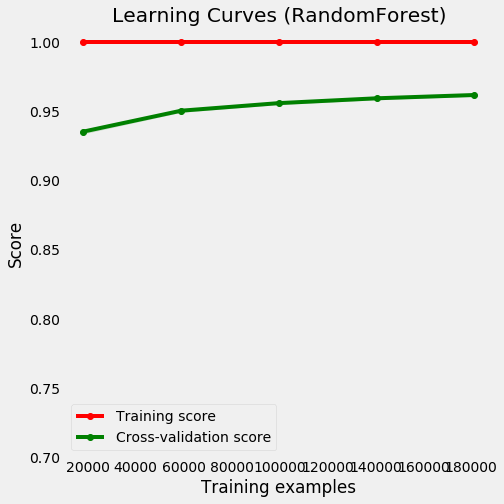

In [43]:
title = "Learning Curves (RandomForest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)  # changed 100 to 50
estimator = RandomForestClassifier(**mdl_params)
ylim = (0.7, 1.01)
n_jobs = 7
train_sizes = np.linspace(.1, 1.0, 5)
fig = plt.figure(figsize=(7, 7))
plt.title(title)
if ylim is not None:
    plt.ylim(*ylim)
plt.xlabel("Training examples")
plt.ylabel("Score")
train_sizes, train_scores, test_scores = learning_curve(
    estimator, all_X, all_y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.tight_layout(pad=0.5, w_pad=20, h_pad=0.5)
plt.show()
# plt.savefig('loanwords.prob.solutions.learningcurve.png')


# Appendix

### Find which texts in the Latin Library have the most transliterated Greek

In [45]:
corpus_files = {}
latin_reader = get_corpus_reader(corpus_name='latin_text_latin_library', language='latin')
greek_in_corpus_selection = set()
found_greek = []

for full_path in tqdm(latin_reader.fileids(), total=len(latin_reader.fileids()), unit='files'):
    filename = full_path[full_path.rfind('/') + 1:]
    unseen_X = process_latin_text_pipeline.fit_transform(list(latin_reader.sents([full_path])))
    distinct_unseen = distinct_words(unseen_X)
    unseen_words = list(distinct_unseen)
    total_words = [word
                   for sentence in unseen_X
                   for word in sentence]
    arr = classifier.predict(np.array([word_to_features(word, max_len) for word in total_words]))
    total_greek_words = np.count_nonzero(arr)
    marks = arr.tolist()
    if marks:
        found_greek = [total_words[idx]
                       for idx, point in enumerate(marks)
                       if point == 1]
        greek_in_corpus_selection |= set(found_greek)
        corpus_files[filename] = (len(total_words), total_greek_words)


100%|██████████| 2141/2141 [1:06:44<00:00,  2.40s/files]


In [46]:
print(f'Total Greek words found in Latin selection {len(greek_in_corpus_selection):,}')
print(f'Number of Greek words not in training data: {len(greek_in_corpus_selection - only_greek_transliterated):,}')
print(f'Random sample: {random.sample(greek_in_corpus_selection, 20)}')

Total Greek words found in Latin selection 16,544
Number of Greek words not in training data: 14,236
Random sample: ['confortationemsi', 'semiadaperta', 'consubstantialitas', 'perniciosaintellegere', 'entechnous', 'Aristodemo', 'quaze', 'Parthenopeia', 'filiias', 'Theodereti', 'sxiamaxai', 'Atlanteos', 'indulgentie', 'Quaedamincremento', 'uigintiquattuor', 'presumptuosi', 'Creten', 'aphrosynas', 'anekdota', 'Romanorumlegati']


In [47]:
print(len(corpus_files ))
rankings = [ (key, val[0], val[1], val[1]/val[0]) for key, val in corpus_files.items()]
rankings.sort(key=lambda x: x[3])
for rank in rankings:
    print (rank)

2039
('preface.txt', 411, 0, 0.0)
('serm18.txt', 1363, 0, 0.0)
('balde1.txt', 109, 0, 0.0)
('gall5.txt', 7489, 0, 0.0)
('legagr3.txt', 1249, 0, 0.0)
('repub4.txt', 202, 0, 0.0)
('dicquid.txt', 52, 0, 0.0)
('dulcesolum.txt', 73, 0, 0.0)
('dumdomus.txt', 46, 0, 0.0)
('dumestas.txt', 13, 0, 0.0)
('eutropius1.txt', 1569, 0, 0.0)
('eutropius9.txt', 2083, 0, 0.0)
('fortunat.txt', 101, 0, 0.0)
('contro.txt', 926, 0, 0.0)
('qualitate.txt', 353, 0, 0.0)
('gaud.txt', 113, 0, 0.0)
('janus2.txt', 2, 0, 0.0)
('jfkhonor.txt', 6, 0, 0.0)
('liv.per.txt', 2, 0, 0.0)
('liv.per1.txt', 444, 0, 0.0)
('liv.per10.txt', 117, 0, 0.0)
('liv.per101.txt', 77, 0, 0.0)
('liv.per102.txt', 97, 0, 0.0)
('liv.per106.txt', 111, 0, 0.0)
('liv.per108.txt', 81, 0, 0.0)
('liv.per11.txt', 198, 0, 0.0)
('liv.per110.txt', 121, 0, 0.0)
('liv.per111.txt', 106, 0, 0.0)
('liv.per112.txt', 129, 0, 0.0)
('liv.per114.txt', 92, 0, 0.0)
('liv.per115.txt', 77, 0, 0.0)
('liv.per117.txt', 125, 0, 0.0)
('liv.per118.txt', 72, 0, 0.0)
('liv.

# That's all for now folks!